In [1]:
%load_ext autoreload

In [46]:
%autoreload 2
from data import TimeSeriesDataset, TimeSeriesConv1dDataset, TimeSeriesNstepsDataset, TimeSeriesNstepsLstmDataset, SberDataset

import lightning as pl
from torch.utils.data import DataLoader
import torch.nn.functional as F 
import torchmetrics as tm

from model_package.nsteps_models import TimeSeriesFcRegressionN, TimeSeriesLstmRegressionN
from model_package.single_step_models import TimeSeriesConv1dRegression, TimeSeriesLstmRegression

import yaml
from utils import *
from pathlib import Path

In [25]:
from warnings import filterwarnings
import seaborn as sns

filterwarnings(action='ignore', category=pl.pytorch.utilities.warnings.PossibleUserWarning)
sns.set()

### 01. Lukoil stock price prediction

In [63]:
path = Path('./data')

augm_path = sorted(path.glob("a*"))[0]
lpaths = sorted(path.glob("L*"))


CONFIG = yaml.safe_load(open('config.yaml'))

#### 01.1 Data processing

In [5]:
timeseries = TimeSeriesDataset(paths=lpaths, 
                               augm_path=augm_path,
                               window_len=3)

In [6]:
train_dataset, test_dataset = time_series_split(timeseries, 
                                                test_size=CONFIG['data']['test_size'])

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

#### 01.2 LSTM Training

In [7]:
net = TimeSeriesLstmRegression(**CONFIG['model']['rnn'])
trainer = pl.Trainer(max_epochs=CONFIG['training']['rnn_n_epochs'])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(net, 
            train_dataloaders=train_loader,
            val_dataloaders=test_loader)

In [10]:
train_predictions = trainer.predict(net, train_loader) 
test_predictions = trainer.predict(net, test_loader) 

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

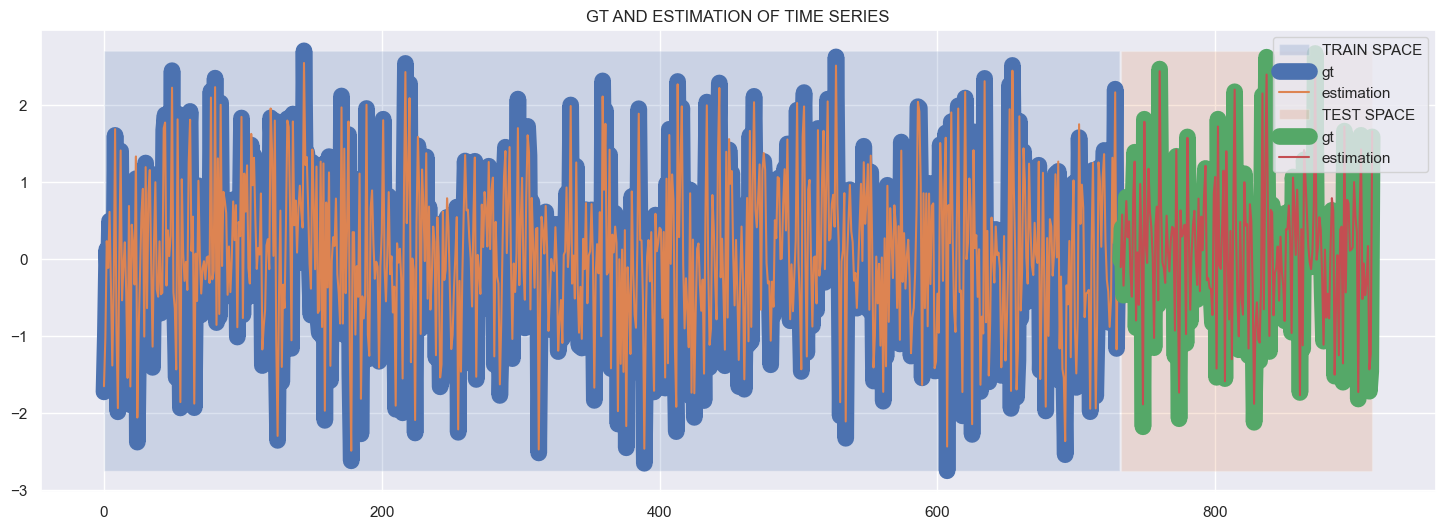

In [11]:
plt.figure(figsize=(18,6))
plot_real_and_predictions(test_dataset, train_dataset,
                          train_predictions, test_predictions)

In [12]:
trainer.validate(net, dataloaders=test_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.12187092006206512    │
│            mse            │    0.02192670665681362    │
│         r2_score          │    0.9672602415084839     │
└───────────────────────────┴───────────────────────────┘

[{'r2_score': 0.9672602415084839,
  'mse': 0.02192670665681362,
  'mae': 0.12187092006206512}]

In [21]:
torch.save(net.state_dict(), 
           "/".join([CONFIG['model_savepath'], net._get_name()]))

#### 01.3 Conv1d Training

In [27]:
timeseries_panel = TimeSeriesConv1dDataset(lpaths, 
                                           augm_path, 
                                           window_len=CONFIG['data']['window_len'])

train_dataset, test_dataset = time_series_split(timeseries_panel, 
                                                test_size=CONFIG['data']['test_size'])

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

In [30]:
trainer = pl.Trainer(max_epochs=CONFIG['training']['cnn_n_epochs'])
net = TimeSeriesConv1dRegression(**CONFIG['model']['conv'], loss=F.mse_loss)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(net, train_dataloaders=train_loader,
            val_dataloaders=test_loader
            )

In [33]:
train_predictions = trainer.predict(net, train_loader) 
test_predictions = trainer.predict(net, test_loader) 

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

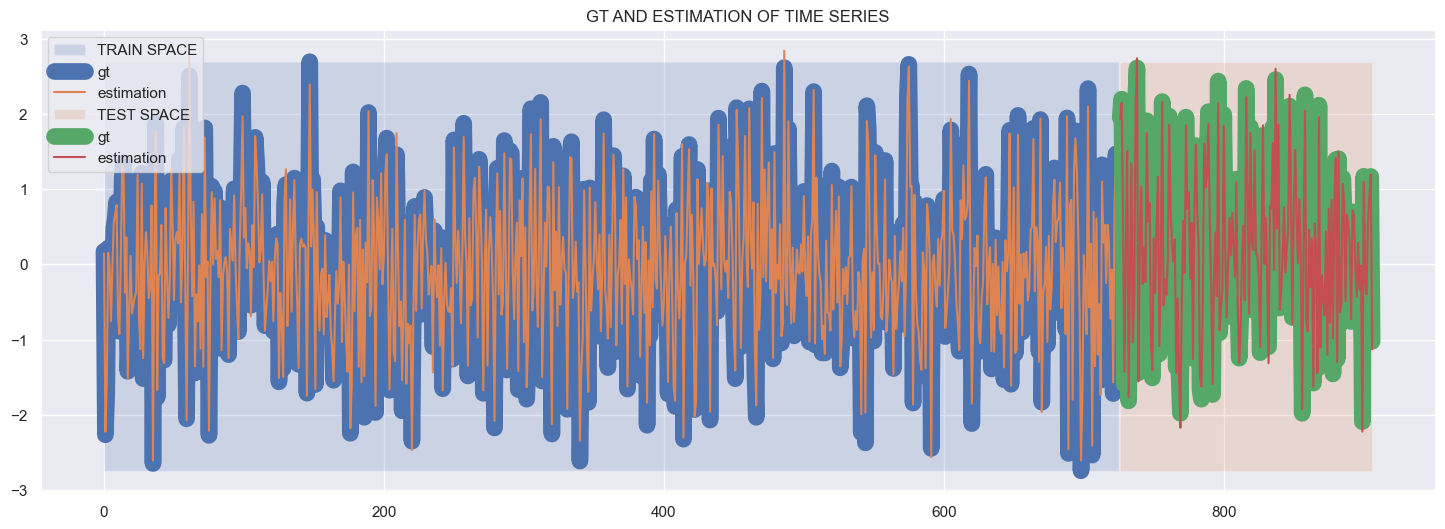

In [34]:
plt.figure(figsize=(18,6))
plot_real_and_predictions(test_dataset, train_dataset,
                          train_predictions, test_predictions)

In [35]:
trainer.validate(net, dataloaders=[test_loader])

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.10946017503738403    │
│            mse            │    0.01945025846362114    │
│         r2_score          │    0.9806369543075562     │
└───────────────────────────┴───────────────────────────┘

[{'r2_score': 0.9806369543075562,
  'mse': 0.01945025846362114,
  'mae': 0.10946017503738403}]

In [38]:
torch.save(net.state_dict(), 
           "/".join([CONFIG['model_savepath'], net._get_name()]))

#### 01.4 FC Training [nsteps]

In [48]:
timeseries_nstep = TimeSeriesNstepsDataset(paths=lpaths, 
                                           augm_path=augm_path,
                                           window_len=CONFIG['data']['window_len'])

In [49]:
train_dataset, test_dataset = time_series_split(timeseries_nstep, 
                                                test_size=0.02)

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

In [50]:
net = TimeSeriesFcRegressionN(**CONFIG['model']['fc_nstep'])
trainer = pl.Trainer(max_epochs=CONFIG['training']['fc_n_epochs'])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(net, 
            train_dataloaders=train_loader)


  | Name      | Type       | Params
-----------------------------------------
0 | regressor | Sequential | 286 K 
-----------------------------------------
286 K     Trainable params
0         Non-trainable params
286 K     Total params
1.146     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [52]:
trainer.validate(net, 
                 dataloaders=test_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.02657187730073929    │
│            mse            │   0.0011714352294802666   │
└───────────────────────────┴───────────────────────────┘

[{'mse': 0.0011714352294802666, 'mae': 0.02657187730073929}]

In [53]:
test_predictions = trainer.predict(net, test_loader)
test_predictions = torch.cat(test_predictions)

Predicting: 0it [00:00, ?it/s]

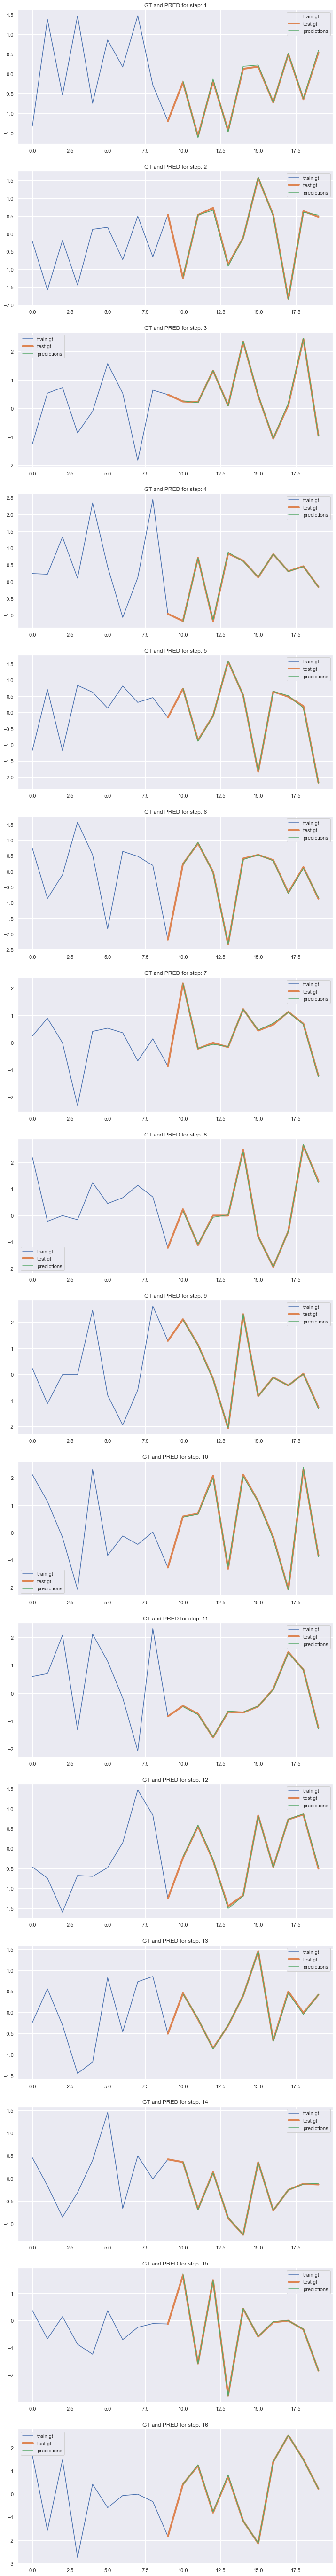

In [227]:
plot_nstep_real_and_predictions(test_dataset, test_predictions)

In [54]:
torch.save(net.state_dict(), 
           "/".join([CONFIG['model_savepath'], net._get_name()]))

#### 01.5 LSTM Training [nsteps]

In [123]:
timeseries_nstep = TimeSeriesNstepsLstmDataset(lpaths, augm_path, 
                                               window_len=CONFIG['data']['window_len'])

train_dataset, test_dataset = time_series_split(timeseries_nstep, 
                                                test_size=0.02)

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

In [126]:
net = TimeSeriesLstmRegressionN(**CONFIG['model']['rnn_nstep'])
trainer = pl.Trainer(max_epochs=CONFIG['training']['rnn_n_epochs'])
trainer.fit(net, 
            train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | enc                  | GRU        | 50.3 K
1 | dec                  | GRU        | 99.1 K
2 | additional_regressor | Sequential | 110   
3 | regressor            | Sequential | 129   
----------------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.598     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [127]:
trainer.validate(net,
                 dataloaders=test_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │   0.011858179233968258    │
│            mse            │  0.00020782131468877196   │
└───────────────────────────┴───────────────────────────┘

[{'mse': 0.00020782131468877196, 'mae': 0.011858179233968258}]

In [128]:
test_predictions = trainer.predict(net, dataloaders=test_loader)
test_predictions = torch.cat(test_predictions)

Predicting: 0it [00:00, ?it/s]

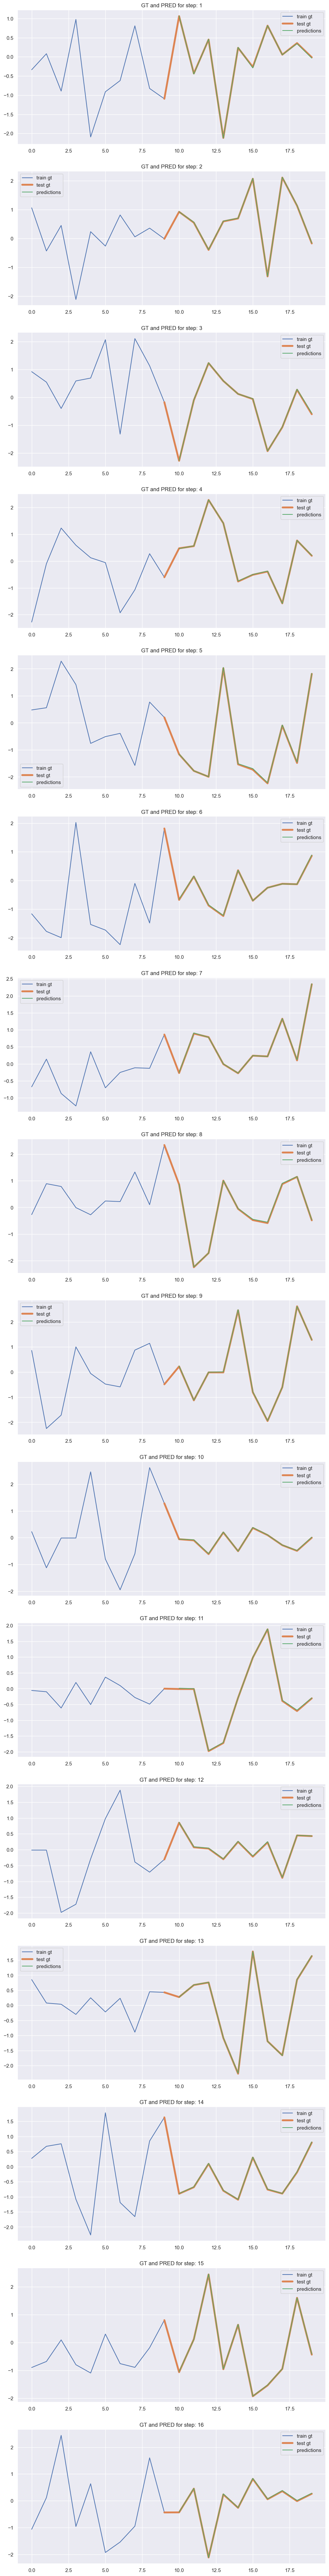

In [129]:
plot_nstep_real_and_predictions(test_dataset, test_predictions)

In [133]:
torch.save(net.state_dict(),
           "/".join([CONFIG['model_savepath'], net._get_name() + "_LUK"]))

#### 02. SBER: stock price prediction

In [136]:
timeseries = SberDataset(sber_path=path, window_len=CONFIG['data']['window_len'])
train_dataset, test_dataset = time_series_split(timeseries, 
                                                test_size=0.1)

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

In [137]:
net = TimeSeriesLstmRegressionN(input_size=1, 
                                hidden_size=128,
                                num_layers=1,
                                bidirectional=False,
                                nsteps=10,
                                loss=F.mse_loss
                                )

In [138]:
trainer = pl.Trainer(max_epochs=CONFIG['training']['rnn_n_epochs'])
trainer.fit(net,
            train_dataloaders=test_loader)
trainer.validate(net, dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | enc                  | GRU        | 50.3 K
1 | dec                  | GRU        | 99.1 K
2 | additional_regressor | Sequential | 110   
3 | regressor            | Sequential | 129   
----------------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.598     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │   0.008358003571629524    │
│            mse            │  0.00011563010048121214   │
└───────────────────────────┴───────────────────────────┘

[{'mse': 0.00011563010048121214, 'mae': 0.008358003571629524}]

Predicting: 0it [00:00, ?it/s]

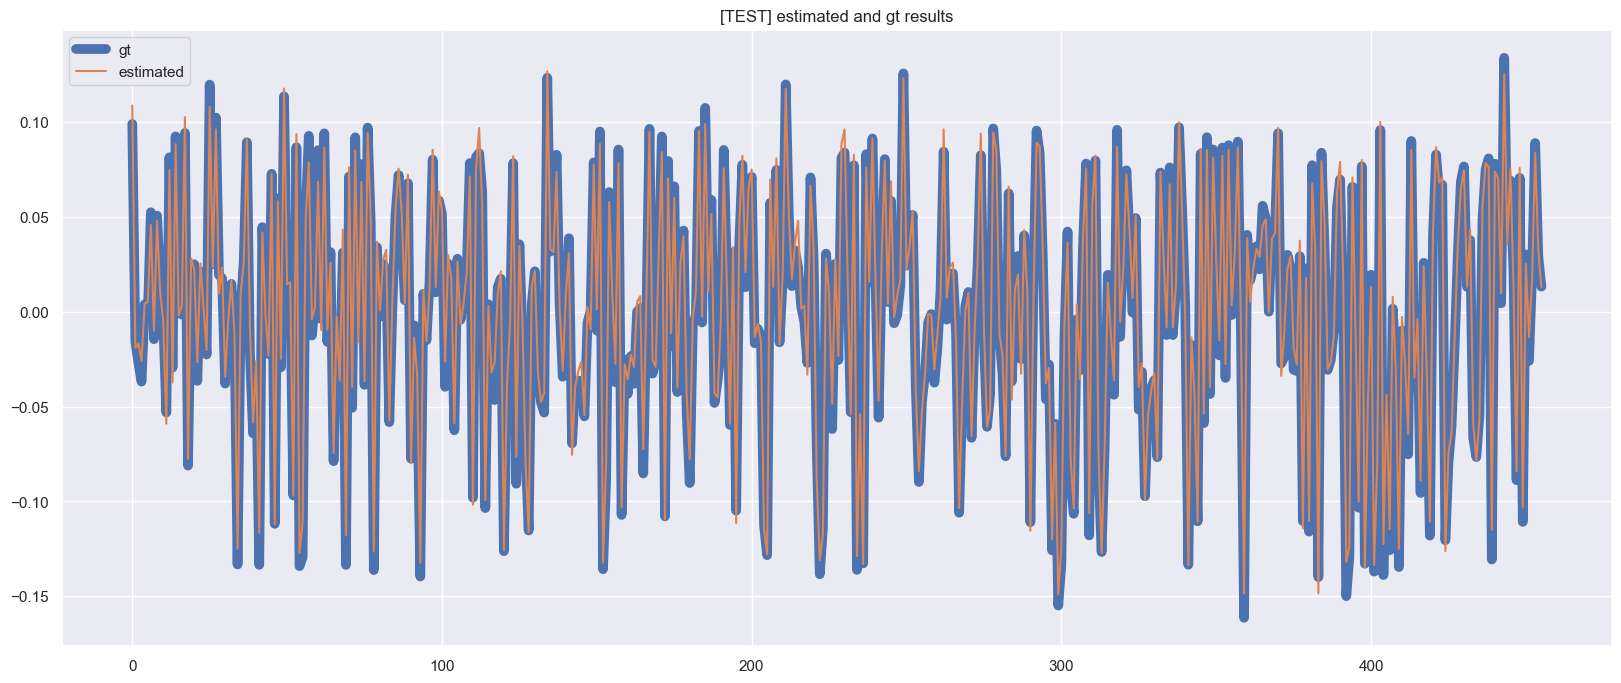

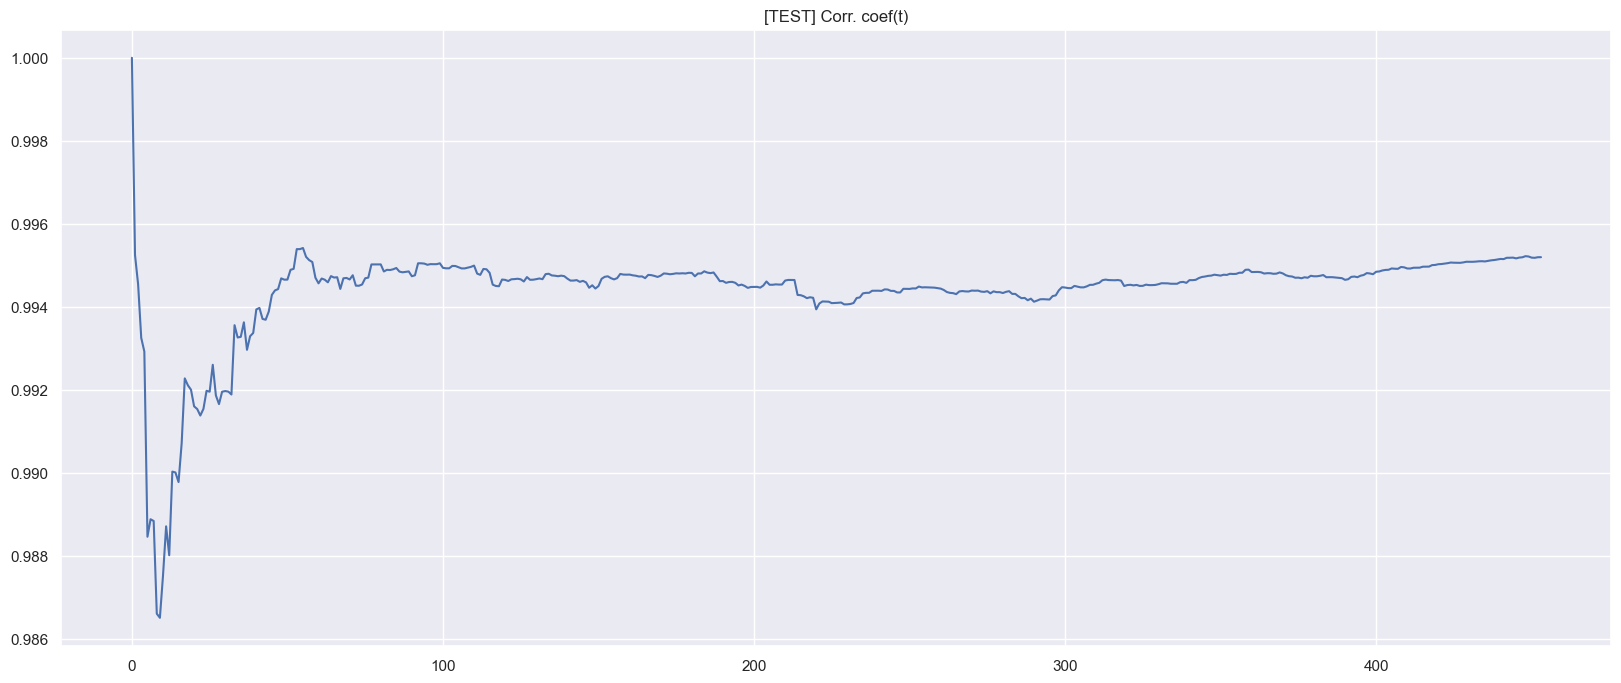

In [139]:
test_predictions = trainer.predict(net, dataloaders=test_loader)
plot_nstep_mono_real_and_predictions(test_dataset, test_predictions)

In [141]:
torch.save(net.state_dict(),
           "/".join([CONFIG['model_savepath'], net._get_name() + "_SBER"]))